#### Basic notebook to look @ convergence of a 2D region in an FES. It will actually call sum hills with the stride you set in cell one , graph the FES and put the regions of convergence there

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from matplotlib.patches import Rectangle



In [2]:
# define all variables for convergence script
# these will pass to the bash magic below used to call plumed sum_hills 
dir="MetaD_converge" #where the intermediate fes will be stored
hills="other/HILLS"  #your HILLS file from the simulation
finalfes='other/fes.dat' #the final fes.dat file 
stride=1000
kT=8.314e-3*300 #throughout we convert to kcal, but the HILLS are assumed to be in GROMACS units (kJ)


## here is where you set the boxes to define convergence regions
C1=[-1.5,1.0] #center of box 1
C2=[1.0,-.5]
edge1=1.0 #edge of box1 
edge2=1.0

In [3]:
%%bash -s "$dir" "$hills" "$stride" "$kT"
# calling sum hills and output to devnul 
HILLSFILE=HILLS
rm -rf $1
mkdir $1
cp $2 $1 
cd $1 
plumed sum_hills --hills $HILLSFILE --kt $4 --stride $3  >& /dev/null 

#### Graph the final FES and plot the two squares on top of it

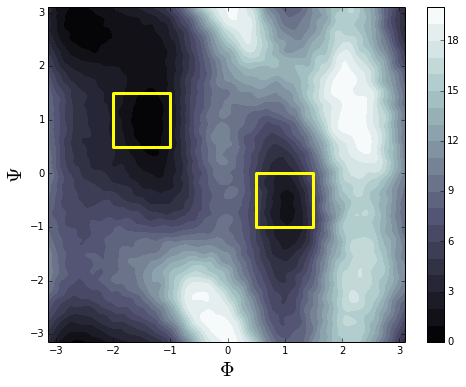

In [4]:
%matplotlib inline

#read the data in from a text file 
fesdata = np.genfromtxt(finalfes,comments='#');

fesdata = fesdata[:,0:3]
#what was your grid size? this calculates it 
dim=int(np.sqrt(np.size(fesdata)/3))

#some post-processing to be compatible with contourf 
X=np.reshape(fesdata[:,0],[dim,dim],order="F")  #order F was 20% faster than A/C
Y=np.reshape(fesdata[:,1],[dim,dim],order="F") 
Z=np.reshape((fesdata[:,2]-np.min(fesdata[:,2]))/4.184,[dim,dim],order="F")  #convert to kcal/mol

#what spacing do you want?  assume units are in kJ/mol
spacer=1  #this means 1kcal/mol spacing
lines=20
levels=np.linspace(0,lines*spacer,num=(lines+1),endpoint=True)

fig=plt.figure(figsize=(8,6)) 
axes = fig.add_subplot(111)

xlabel='$\Phi$'
ylabel='$\Psi$'
plt.contourf(X, Y, Z, levels, cmap=plt.cm.bone,)
plt.colorbar()
axes.set_xlabel(xlabel, fontsize=20)
axes.set_ylabel(ylabel, fontsize=20)

currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((C1[0]-edge1/2, C1[1]-edge1/2), edge1, edge1,facecolor='none',edgecolor='yellow',linewidth='3'))
currentAxis.add_patch(Rectangle((C2[0]-edge2/2, C2[1]-edge2/2), edge2, edge2,facecolor='none',edgecolor='yellow',linewidth='3'))

plt.show()



The two functions below calculate the average free energy of a region by integrating over whichever boxes you defined above.  Since the FES is discrete and points are equally spaced, this is trivially taken as a summation: 

$F_A = -k_BT * ln \sum_A exp\left(-F_{Ai}/k_BT\right) $

Don't forget that this is formally a free-energy plus some trivial constant but that the constant is equal for both regions $A$ and $B$ so that you will obtain the same free-energy difference irrespective of the reference point. 

On the other hand, it doesn't make much sense to just use the arbitrary nubmers coming from sum_hills, which are related only to the amount of aggregate bias produced in your simulation.  This is why we reference the lowest point to zero on the contour plots.

I left both functions in as a teaching tool to show how slow np.genfromtext is 

In [5]:
def diffNP(file):
    #read the data in from a text file 
    # note - this is very slow 
    fesdata = np.genfromtxt(file,comments='#');
    A=0.0
    B=0.0

    dim=np.shape(fesdata)[0]
    for i in range(0, dim):
        x=fesdata[i][0]
        y=fesdata[i][1]
        z=fesdata[i][2]
        if  x < C1[0]+edge1/2 and x > C1[0]-edge1/2 and y > C1[1]-edge1/2 and y < C1[1]+edge1/2:
           A+=np.exp(-z/kT)
        if  x < C2[0]+edge2/2 and x > C2[0]-edge2/2 and y > C2[1]-edge2/2 and y < C2[1]+edge2/2:
           B+=np.exp(-z/kT)

    A=-kT*np.log(A)
    B=-kT*np.log(B)
    diff=(A-B)/4.184 #output in kcal
    return diff

In [6]:
def diff(file):

    kT=8.314e-3*300
    A=0.0
    B=0.0
    f = open(file, 'r')
    for line in f:
        if line[:1] != '#':
            line=line.strip()
            if line:
                columns = line.split()
                x=float(columns[0])
                y=float(columns[1])
                z=float(columns[2])
                if  x < C1[0]+edge1/2 and x > C1[0]-edge1/2 and y > C1[1]-edge1/2 and y < C1[1]+edge1/2:
                    A+=np.exp(-z/kT)
                if  x < C2[0]+edge2/2 and x > C2[0]-edge2/2 and y > C2[1]-edge2/2 and y < C2[1]+edge2/2:
                    B+=np.exp(-z/kT)

    f.close

    A=-kT*np.log(A)
    B=-kT*np.log(B)
    diff=(A-B)/4.184
    return diff

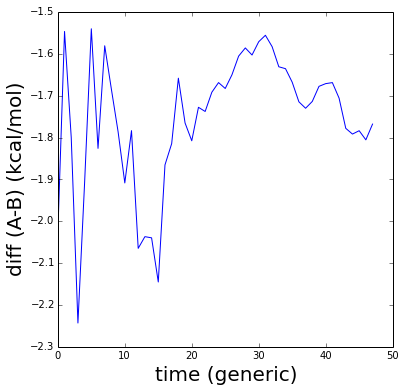

In [7]:
diffvec=None
rootdir = '/Users/jpfaendt/Learning/Python/ALA2_MetaD/MetaD_converge'
i=0
diffvec=np.zeros((1,2))

#the variable func defines which function you are going to call to read in your data files fes_*.dat
#func=diffNP uses the numpy read in (SLOW)
#func=diff streams in data from a text file
#to experience the differnece , uncomment out the print statements and run each way

func=diff
for infile in glob.glob( os.path.join(rootdir, 'fes_?.dat') ):
    if i >= i:
            diffvec.resize((i+1,2))
    #print "current file is: " + infile
    diffvec[i][0]=i*1.0
    diffvec[i][1]=func(infile)
    i+=1

for infile in glob.glob( os.path.join(rootdir, 'fes_??.dat') ):
    if i >= i:
            diffvec.resize((i+1,2))
    #print "current file is: " + infile
    diffvec[i][0]=i*1.0
    diffvec[i][1]=func(infile)
    i+=1

for infile in glob.glob( os.path.join(rootdir, 'fes_???.dat') ):
    if i >= i:
            diffvec.resize((i+1,2))
    #print "current file is: " + infile
    diffvec[i][0]=i*1.0
    diffvec[i][1]=func(infile)
    i+=1
    
fig = plt.figure(figsize=(6,6)) 
axes = fig.add_subplot(111)
xlabel='time (generic)'
ylabel='diff (A-B) (kcal/mol)'
axes.plot(diffvec[:,0],diffvec[:,1])
axes.set_xlabel(xlabel, fontsize=20)
axes.set_ylabel(ylabel, fontsize=20)

plt.show()


### Below this is all testing of different read-in options:

In [165]:
## 
#read the data in from a text file using genfrom txt
fesdata = np.genfromtxt('MetaD_converge/fes_1.dat',comments='#');
kT=8.314e-3*300
A=0.0
B=0.0
                   
dim=np.shape(fesdata)[0]
for i in range(0, dim):
    x=fesdata[i][0]
    y=fesdata[i][1]
    z=fesdata[i][2]
    if  x < C1[0]+edge1/2 and x > C1[0]-edge1/2 and y > C1[1]-edge1/2 and y < C1[1]+edge1/2:
       A+=np.exp(-z/kT)
    if  x < C2[0]+edge2/2 and x > C2[0]-edge2/2 and y > C2[1]-edge2/2 and y < C2[1]+edge2/2:
       B+=np.exp(-z/kT)
   
A=-kT*np.log(A)
B=-kT*np.log(B)
diff=(A-B)/4.184
diff

-5.9385445884388588

In [164]:
## 
#read the data in from a text file using read in commands
kT=8.314e-3*300
A=0.0
B=0.0


f = open('MetaD_converge/fes_1.dat', 'r')
for line in f:
    if line[:1] != '#':
        line=line.strip()
        if line:
            columns = line.split()
            x=float(columns[0])
            y=float(columns[1])
            z=float(columns[2])
            if  x < C1[0]+edge1/2 and x > C1[0]-edge1/2 and y > C1[1]-edge1/2 and y < C1[1]+edge1/2:
                A+=np.exp(-z/kT)
            if  x < C2[0]+edge2/2 and x > C2[0]-edge2/2 and y > C2[1]-edge2/2 and y < C2[1]+edge2/2:
                B+=np.exp(-z/kT)

f.close
            

A=-kT*np.log(A)
B=-kT*np.log(B)
diff=(A-B)/4.184
diff

-5.9385445884388588

#### Profiling speed of different read in options:

In [123]:
file='MetaD/fes.dat'

In [169]:
%timeit diffNP(file)

10 loops, best of 3: 207 ms per loop


In [170]:
%timeit diff(file)

10 loops, best of 3: 51.4 ms per loop
